In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
from tqdm import tqdm
import copy
import os
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from scipy.stats import binomtest

# To ignore warnings
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [53]:
EPS = 1e-5
BASELINE_F1 = 0.7758620689655172

In [54]:
class Scaler():
    def __init__(self, eps=EPS):
        self.mean = None
        self.std = None
        self.eps = eps

    def fit(self, x):
        self.mean = x.mean(axis=0, keepdims=True)
        self.std = x.std(axis=0, keepdims=True)

    def normalize(self, x):
        """
        Normalizes the data x (of shape (n, d))
        """
        normalized_x = x - self.mean
        normalized_x /= (self.std + EPS)
        return normalized_x

In [55]:
class MLPProbe(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.linear1 = nn.Linear(d, 100)
        self.linear2 = nn.Linear(100, 1)

    def forward(self, x):
        h = F.relu(self.linear1(x))
        o = self.linear2(h)
        return torch.sigmoid(o)

class CCS(object):
    def __init__(self, x0, x1, nepochs=1000, ntries=50, lr=1e-3, batch_size=64, 
                 verbose=False, device="mps", linear=True, weight_decay=0.01):
        # data
        self.scaler0 = Scaler()
        self.scaler1 = Scaler()
        self.scaler0.fit(x0)
        self.scaler1.fit(x1)

        self.x0 = self.scaler0.normalize(x0)
        self.x1 = self.scaler1.normalize(x1)
        self.d = self.x0.shape[-1]

        # training
        self.nepochs = nepochs
        self.ntries = ntries
        self.lr = lr
        self.verbose = verbose
        self.device = device
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        
        # probe
        self.linear = linear
        self.initialize_probe()
        self.best_probe = copy.deepcopy(self.probe)

        
    def initialize_probe(self):
        if self.linear:
            self.probe = nn.Sequential(nn.Linear(self.d, 1), nn.Sigmoid())
        else:
            self.probe = MLPProbe(self.d)
        self.probe.to(self.device)    

        
    def get_tensor_data(self):
        """
        Returns x0, x1 as appropriate tensors (rather than np arrays)
        """
        x0 = torch.tensor(self.x0, dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.x1, dtype=torch.float, requires_grad=False, device=self.device)
        return x0, x1
    

    def get_loss(self, p0, p1):
        """
        Returns the CCS loss for two probabilities each of shape (n,1) or (n,)
        """
        informative_loss = (torch.min(p0, p1)**2).mean(0)
        consistent_loss = ((p0 - (1-p1))**2).mean(0)
        return informative_loss + consistent_loss


    def get_acc(self, x0_test, x1_test, y_test):
        """
        Computes accuracy for the current parameters on the given test inputs
        """
        x0 = torch.tensor(self.scaler0.normalize(x0_test), dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.scaler1.normalize(x1_test), dtype=torch.float, requires_grad=False, device=self.device)
        with torch.no_grad():
            p0, p1 = self.best_probe(x0), self.best_probe(x1)
        avg_confidence = 0.5*(p0 + (1-p1))
        predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
        acc = (predictions == y_test).mean()
        acc = max(acc, 1 - acc)

        return acc
    
        
    def train(self):
        """
        Does a single training run of nepochs epochs
        """
        x0, x1 = self.get_tensor_data()
        permutation = torch.randperm(len(x0))
        x0, x1 = x0[permutation], x1[permutation]
        
        # set up optimizer
        optimizer = torch.optim.AdamW(self.probe.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        batch_size = len(x0) if self.batch_size == -1 else self.batch_size
        nbatches = len(x0) // batch_size

        # Start training (full batch)
        for epoch in range(self.nepochs):
            for j in range(nbatches):
                x0_batch = x0[j*batch_size:(j+1)*batch_size]
                x1_batch = x1[j*batch_size:(j+1)*batch_size]
            
                # probe
                p0, p1 = self.probe(x0_batch), self.probe(x1_batch)
                # get the corresponding loss
                loss = self.get_loss(p0, p1)

                # update the parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return loss.detach().cpu().item()
    
    def repeated_train(self):
        best_loss = np.inf
        for train_num in range(self.ntries):
            self.initialize_probe()
            loss = self.train()
            if loss < best_loss:
                self.best_probe = copy.deepcopy(self.probe)
                best_loss = loss

        return best_loss
    
    def predict(self, pos, neg):
        x0 = torch.tensor(self.scaler0.normalize(pos), dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.scaler1.normalize(neg), dtype=torch.float, requires_grad=False, device=self.device)
        with torch.no_grad():
            p0, p1 = self.best_probe(x0), self.best_probe(x1)
        avg_confidence = 0.5*(p0 + (1-p1))
        predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
        return predictions

In [56]:
def unstack_prompts(data):
    return data.transpose(0, 3, 1, 2).reshape(data.shape[0] * data.shape[3], data.shape[1], data.shape[2])

def process_data(saved_names, verbose=False):
    """
    1. Loads data
    2. Stacks into numpy shape (professions x layers x dim x prompts)
    3. Undersample majority class if needed
    4. Split into train/test split across professions dim
    5. Unstacks prompts into (professions * prompts x layers x dim)
    Output shape:
        hs: (professions * prompts x layers x dim)
        y: (professions * prompts)
    """
    path = os.path.join(os.getcwd(), "saved")
    total_neg = []
    total_pos = []
    total_y = []
    # Load all results
    for saved_name in saved_names:
        root = os.path.join(path, saved_name)
        total_neg.append(np.load(os.path.join(root, "fem-hs.npy")))
        total_pos.append(np.load(os.path.join(root, "male-hs.npy")))
        total_y.append(np.load(os.path.join(root, "y.npy")))

    # Stack results on last dim
    neg_hs_layers = np.stack(total_neg, axis=-1)
    pos_hs_layers = np.stack(total_pos, axis=-1)
    y = np.stack(total_y, axis=-1)

    # Randomly permute
    n = y.shape[0]
    p = np.random.permutation(n)
    neg_hs_layers = neg_hs_layers[p]
    pos_hs_layers = pos_hs_layers[p]
    y = y[p]

    # Train test split
    # We want to maintain our label proportions
    neg_hs_train, neg_hs_test, pos_hs_train, pos_hs_test, y_train, y_test = train_test_split(neg_hs_layers, 
                                                                                             pos_hs_layers, 
                                                                                             y, 
                                                                                             test_size=0.2, 
                                                                                             shuffle=True, 
                                                                                             stratify=y)
    

    # Undo stack on dim=-1 to ungroup prompts from professions
    neg_hs_train = unstack_prompts(neg_hs_train)
    neg_hs_test = unstack_prompts(neg_hs_test)
    pos_hs_train = unstack_prompts(pos_hs_train)
    pos_hs_test = unstack_prompts(pos_hs_test)
    y_train = y_train.reshape(y_train.shape[0] * y_train.shape[1])
    y_test = y_test.reshape(y_test.shape[0] * y_test.shape[1])

    if verbose:
        print(neg_hs_train.shape, pos_hs_train.shape, y_train.shape, neg_hs_test.shape, pos_hs_test.shape, y_test.shape)

    return (neg_hs_train, pos_hs_train, y_train), (neg_hs_test, pos_hs_test, y_test)

In [57]:
@ignore_warnings(category=ConvergenceWarning)
def train_lr(train_data, test_data, verbose=True):
    """
    Trains and evaluates logistic regression on difference of pos and neg hs
    Input: tuples of (neg_hs, pos_hs, y)
    """
    neg_hs_train, pos_hs_train, y_train = train_data
    neg_hs_test, pos_hs_test, y_test = test_data

    # Scale hidden states
    scaler0 = Scaler()
    scaler1 = Scaler()
    scaler0.fit(neg_hs_train)
    scaler1.fit(pos_hs_train)
    neg_hs_train = scaler0.normalize(neg_hs_train)
    pos_hs_train = scaler1.normalize(pos_hs_train)
    neg_hs_test = scaler0.normalize(neg_hs_test)
    pos_hs_test = scaler1.normalize(pos_hs_test)

    # for simplicity we can just take the difference between positive and negative hidden states
    # (concatenating also works fine)
    x_train = neg_hs_train - pos_hs_train
    lr = LogisticRegression(class_weight="balanced")
    lr.fit(x_train, y_train)
    
    x_test = neg_hs_test - pos_hs_test
    lr_pred = lr.predict(x_test)
    f1 = f1_score(y_test, lr_pred)
    acc = accuracy_score(y_test, lr_pred)
    # k = (y_test == lr_pred).sum()
    # p = y_test.sum() / len(y_test)
    if verbose:
        print(f"lr f1 score: {f1}")
        print(f"lr accuracy: {acc}")
        # print(f"p-value: {binomtest(k, len(y_test),p=p, alternative='greater').pvalue}")
        print(confusion_matrix(y_test, lr_pred))

    return lr, f1

In [58]:
def train_ccs(train_data, test_data, verbose=True):
    """
    Trains and evaluates ccs
    Input: tuples of (neg_hs, pos_hs, y)
    """
    neg_hs_train, pos_hs_train, y_train = train_data
    neg_hs_test, pos_hs_test, y_test = test_data

    ccs = CCS(neg_hs_train, pos_hs_train, batch_size=-1, nepochs=100)
    loss = ccs.repeated_train()

    # Normalize our test vectors
    y_pred = ccs.predict(ccs.scaler0.normalize(neg_hs_test), ccs.scaler1.normalize(pos_hs_test))
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    # k = (y_test == y_pred).sum()
    # p = y_test.sum() / len(y_test)
    if verbose:
        print(f"ccs f1 score: {f1}")
        print(f"ccs accuracy: {acc}")
        # print(f"p-value: {binomtest(k, len(y_test), p=p, alternative='greater').pvalue}")
        print(confusion_matrix(y_test, y_pred))

    return ccs, f1

In [59]:
def plot_f1(ccs_f1s, lr_f1s):
    # Scatter points
    plt.scatter(range(len(ccs_f1s)), ccs_f1s, label="ccs")
    plt.scatter(range(len(lr_f1s)), lr_f1s, label="lr")
    # Horizontal line at 0.5
    plt.axhline(y=BASELINE_F1, color="r", linestyle="-")
    # Set range
    plt.ylim(0, 1)
    plt.title("F1 score by Layer")
    plt.xlabel("Layer")
    plt.ylabel("F1 score")
    plt.legend()
    plt.show()

In [60]:
def train_layers(saved_names: list, layers=None):
    """
    Trains a CCS and LR predictor for each layer of the data.
    saved names: list of saved hidden states to train on.
    layers: list of layers to train on
    """
    train_data, test_data = process_data(saved_names)

    ccs_f1s = []
    lr_f1s = []

    if layers == None:
        layers = range(train_data[0].shape[1])

    for layer in tqdm(layers):
        train_layer = (train_data[0][:,layer,:], train_data[1][:,layer,:], train_data[2])
        test_layer = (test_data[0][:,layer,:], test_data[1][:,layer,:], test_data[2])
        ccs, ccs_f1 = train_ccs(train_layer, test_layer)
        l1, lr_f1 = train_lr(train_layer, test_layer)

        ccs_f1s.append(ccs_f1)
        lr_f1s.append(lr_f1)
    return ccs_f1s, lr_f1s

  4%|▍         | 1/25 [00:26<10:29, 26.23s/it]

ccs f1 score: 0.0
ccs accuracy: 0.22413793103448276
[[ 65   0]
 [225   0]]
lr f1 score: 0.0
lr accuracy: 0.22413793103448276
[[ 65   0]
 [225   0]]
ccs f1 score: 0.5235294117647059
ccs accuracy: 0.4413793103448276
[[ 39  26]
 [136  89]]


  8%|▊         | 2/25 [00:54<10:33, 27.55s/it]

lr f1 score: 0.8747152619589977
lr accuracy: 0.8103448275862069
[[ 43  22]
 [ 33 192]]
ccs f1 score: 0.5235294117647059
ccs accuracy: 0.4413793103448276
[[ 39  26]
 [136  89]]


 12%|█▏        | 3/25 [01:22<10:05, 27.54s/it]

lr f1 score: 0.8309859154929576
lr accuracy: 0.7517241379310344
[[ 41  24]
 [ 48 177]]
ccs f1 score: 0.6493506493506493
ccs accuracy: 0.5344827586206896
[[ 30  35]
 [100 125]]


 16%|█▌        | 4/25 [01:49<09:34, 27.35s/it]

lr f1 score: 0.8590909090909091
lr accuracy: 0.7862068965517242
[[ 39  26]
 [ 36 189]]


 20%|██        | 5/25 [02:16<09:08, 27.41s/it]

ccs f1 score: 0.31802120141342755
ccs accuracy: 0.33448275862068966
[[ 52  13]
 [180  45]]
lr f1 score: 0.8662131519274376
lr accuracy: 0.7965517241379311
[[ 40  25]
 [ 34 191]]
ccs f1 score: 0.4744744744744745
ccs accuracy: 0.39655172413793105
[[ 36  29]
 [146  79]]


 24%|██▍       | 6/25 [02:43<08:37, 27.25s/it]

lr f1 score: 0.8571428571428572
lr accuracy: 0.7793103448275862
[[ 34  31]
 [ 33 192]]


 28%|██▊       | 7/25 [03:10<08:05, 26.98s/it]

ccs f1 score: 0.4878048780487806
ccs accuracy: 0.4206896551724138
[[ 42  23]
 [145  80]]
lr f1 score: 0.7943925233644858
lr accuracy: 0.696551724137931
[[ 32  33]
 [ 55 170]]


 32%|███▏      | 8/25 [03:36<07:34, 26.71s/it]

ccs f1 score: 0.4785276073619632
ccs accuracy: 0.41379310344827586
[[ 42  23]
 [147  78]]
lr f1 score: 0.8083140877598153
lr accuracy: 0.7137931034482758
[[ 32  33]
 [ 50 175]]
ccs f1 score: 0.4984984984984984
ccs accuracy: 0.4241379310344828
[[ 40  25]
 [142  83]]


 36%|███▌      | 9/25 [04:02<07:06, 26.64s/it]

lr f1 score: 0.8755760368663594
lr accuracy: 0.8137931034482758
[[ 46  19]
 [ 35 190]]
ccs f1 score: 0.3762376237623763
ccs accuracy: 0.3482758620689655
[[ 44  21]
 [168  57]]


 40%|████      | 10/25 [04:33<06:59, 27.95s/it]

lr f1 score: 0.8578088578088578
lr accuracy: 0.7896551724137931
[[ 45  20]
 [ 41 184]]
ccs f1 score: 0.7407407407407407
ccs accuracy: 0.6137931034482759
[[ 18  47]
 [ 65 160]]


 44%|████▍     | 11/25 [05:01<06:29, 27.83s/it]

lr f1 score: 0.886836027713626
lr accuracy: 0.8310344827586207
[[ 49  16]
 [ 33 192]]


 48%|████▊     | 12/25 [05:30<06:06, 28.16s/it]

ccs f1 score: 0.6917293233082706
ccs accuracy: 0.5758620689655173
[[ 29  36]
 [ 87 138]]
lr f1 score: 0.8721461187214611
lr accuracy: 0.8068965517241379
[[ 43  22]
 [ 34 191]]


 52%|█████▏    | 13/25 [05:58<05:37, 28.15s/it]

ccs f1 score: 0.31802120141342755
ccs accuracy: 0.33448275862068966
[[ 52  13]
 [180  45]]
lr f1 score: 0.8787185354691076
lr accuracy: 0.8172413793103448
[[ 45  20]
 [ 33 192]]
ccs f1 score: 0.31802120141342755
ccs accuracy: 0.33448275862068966
[[ 52  13]
 [180  45]]


 56%|█████▌    | 14/25 [06:27<05:13, 28.50s/it]

lr f1 score: 0.8695652173913043
lr accuracy: 0.803448275862069
[[ 43  22]
 [ 35 190]]
ccs f1 score: 0.7209876543209877
ccs accuracy: 0.6103448275862069
[[ 31  34]
 [ 79 146]]


 60%|██████    | 15/25 [07:00<04:58, 29.82s/it]

lr f1 score: 0.8656036446469247
lr accuracy: 0.7965517241379311
[[ 41  24]
 [ 35 190]]
ccs f1 score: 0.44089456869009575
ccs accuracy: 0.39655172413793105
[[ 46  19]
 [156  69]]


 64%|██████▍   | 16/25 [07:28<04:24, 29.38s/it]

lr f1 score: 0.8808988764044943
lr accuracy: 0.8172413793103448
[[ 41  24]
 [ 29 196]]
ccs f1 score: 0.5
ccs accuracy: 0.4413793103448276
[[ 47  18]
 [144  81]]


 68%|██████▊   | 17/25 [07:57<03:53, 29.15s/it]

lr f1 score: 0.8997772828507795
lr accuracy: 0.8448275862068966
[[ 43  22]
 [ 23 202]]


 72%|███████▏  | 18/25 [08:24<03:18, 28.42s/it]

ccs f1 score: 0.0
ccs accuracy: 0.22413793103448276
[[ 65   0]
 [225   0]]
lr f1 score: 0.8844444444444445
lr accuracy: 0.8206896551724138
[[ 39  26]
 [ 26 199]]
ccs f1 score: 0.7714285714285715
ccs accuracy: 0.6689655172413793
[[ 32  33]
 [ 63 162]]


 76%|███████▌  | 19/25 [08:52<02:49, 28.26s/it]

lr f1 score: 0.890380313199105
lr accuracy: 0.8310344827586207
[[ 42  23]
 [ 26 199]]


 80%|████████  | 20/25 [09:19<02:19, 27.90s/it]

ccs f1 score: 0.6750629722921915
ccs accuracy: 0.5551724137931034
[[ 27  38]
 [ 91 134]]
lr f1 score: 0.912280701754386
lr accuracy: 0.8620689655172413
[[ 42  23]
 [ 17 208]]


 84%|████████▍ | 21/25 [09:44<01:48, 27.06s/it]

ccs f1 score: 0.5147928994082841
ccs accuracy: 0.43448275862068964
[[ 39  26]
 [138  87]]
lr f1 score: 0.8749999999999999
lr accuracy: 0.8068965517241379
[[ 38  27]
 [ 29 196]]


 88%|████████▊ | 22/25 [10:10<01:20, 26.98s/it]

ccs f1 score: 0.49079754601226994
ccs accuracy: 0.42758620689655175
[[ 44  21]
 [145  80]]
lr f1 score: 0.8775055679287305
lr accuracy: 0.8103448275862069
[[ 38  27]
 [ 28 197]]


 92%|█████████▏| 23/25 [10:36<00:53, 26.59s/it]

ccs f1 score: 0.4596273291925467
ccs accuracy: 0.4
[[ 42  23]
 [151  74]]
lr f1 score: 0.8838268792710706
lr accuracy: 0.8241379310344827
[[ 45  20]
 [ 31 194]]


 96%|█████████▌| 24/25 [11:02<00:26, 26.29s/it]

ccs f1 score: 0.5235294117647059
ccs accuracy: 0.4413793103448276
[[ 39  26]
 [136  89]]
lr f1 score: 0.867579908675799
lr accuracy: 0.8
[[ 42  23]
 [ 35 190]]


100%|██████████| 25/25 [11:27<00:00, 27.50s/it]

ccs f1 score: 0.31802120141342755
ccs accuracy: 0.33448275862068966
[[ 52  13]
 [180  45]]
lr f1 score: 0.8545454545454546
lr accuracy: 0.7793103448275862
[[ 38  27]
 [ 37 188]]


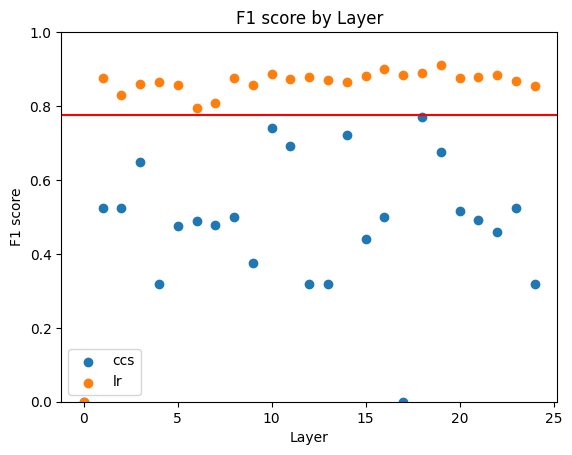

In [61]:
# This ensures we always get the same random sample
np.random.seed(42)
SAVE = True
# trial_names = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"]
trials = [
    {"trial_name": "roberta-large_all-prompts",
     "saved_names": [f"roberta-large_prompt{i}" for i in range(5)]},
     {"trial_name": "roberta-base_all-prompts",
     "saved_names": [f"roberta-base_prompt{i}" for i in range(5)]},
     {"trial_name": "gpt2_all-prompts",
     "saved_names": [f"gpt2_prompt{i}" for i in range(5)]},
     {"trial_name": "gpt2-medium_all-prompts",
     "saved_names": [f"gpt2-medium_prompt{i}" for i in range(5)]},
     {"trial_name": "gpt2-large_all-prompts",
     "saved_names": [f"gpt2-large_prompt{i}" for i in range(5)]},
     {"trial_name": "gpt2-xl_all-prompts",
     "saved_names": [f"gpt2-xl_prompt{i}" for i in range(5)]},
]
for trial in trials:
    ccs_f1s, lr_f1s = train_layers(trial["saved_names"])
    plot_f1(ccs_f1s, lr_f1s)

    if SAVE:
        results_dir = f"results/{trial['trial_name']}"
        if not os.path.exists(os.path.join(os.getcwd(), results_dir)):
            os.mkdir(os.path.join(os.getcwd(), results_dir))
        np.save(os.path.join(os.getcwd(), f"results/{trial['trial_name']}/ccs_f1s.npy"), np.array(ccs_f1s))
        np.save(os.path.join(os.getcwd(), f"results/{trial['trial_name']}/lr_f1s.npy"), np.array(lr_f1s))

        with open(f"results/{trial['trial_name']}/results.txt", "w") as f:
            f.write(f"{trial['trial_name']}\nccs\t{max(ccs_f1s)}\nlr\t{max(lr_f1s)}")